In [ ]:
import pandas as pd
import numpy as np
import tejapi
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
tej_key = 'your key'
tejapi.ApiConfig.api_key = tej_key
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = tej_key


from zipline.sources.TEJ_Api_Data import get_universe
import TejToolAPI
from zipline.data.run_ingest import simple_ingest
from zipline.api import set_slippage, set_commission, set_benchmark,  symbol,  record, order_target_percent
from zipline.finance import commission, slippage
from zipline import run_algorithm
from scipy.optimize import minimize

In [2]:
start_date = '2010-01-01'; end_date = '2025-04-21'

pool = get_universe(start = start_date,
                      end = end_date,
                      mkt_bd_e = ['TSE', 'OTC'],
                      stktp_e = 'Common Stock',
                      main_ind_e = 'General Industry')

columns = ['coid','roi', 'mktcap', 'r501', 'r104', 'cscfo', 'cscfi', 'r401', 'r405']

start_dt = pd.Timestamp(start_date, tz = 'UTC')
end_dt = pd.Timestamp(end_date, tz = "UTC")

data_use = TejToolAPI.get_history_data(start = start_dt,
                                    end = end_dt,
                                    ticker = pool,
                                    fin_type = 'Q', # 為累計資料
                                    columns = columns,
                                    transfer_to_chinese = False)

Currently used TEJ API key call quota 15/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 16829331/9223372036854775807 (0.0%)
Currently used TEJ API key call quota 94/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 22888596/9223372036854775807 (0.0%)


In [3]:
data_use = data_use.sort_values(['coid', 'mdate'])

In [4]:
data_use['Avg_Market_Cap_Per_Day'] = data_use.groupby('mdate')['Market_Cap_Dollars'].transform('mean')
data_use['Avg_Current_Ratio_Per_Day'] = data_use.groupby('mdate')['Current_Ratio_Q'].transform('mean')
data_use['Avg_Return_Rate_on_Equity_Per_Day'] = data_use.groupby('mdate')['Return_Rate_on_Equity_A_percent_Q'].transform('mean')
data_use['Free_Cash_Flow'] = data_use['Cash_Flow_from_Operating_Activities_Q'] - data_use['Cash_Flow_from_Investing_Activities_Q']

# 確保資料依公司與時間排序
data_use = data_use.sort_values(['coid', 'mdate'])
# 使用 rolling() 計算近四季平均 ROE（min_periods=4 確保要有滿4筆才計算）
data_use['Avg_ROE_4Q'] = data_use.groupby('coid')['Return_Rate_on_Equity_A_percent_Q'] \
                                 .transform(lambda x: x.rolling(window=252, min_periods=252).mean())

# 使用 rolling() 計算近四季平均營收成長率
data_use['Avg_Sales_Growth_4Q'] = data_use.groupby('coid')['Sales_Growth_Rate_Q'] \
                                          .transform(lambda x: x.rolling(window=252, min_periods=252).mean())

data_use['Avg_NI_Growth_4Q'] = data_use.groupby('coid')['Net_Income_Growth_Rate_Q'] \
                                          .transform(lambda x: x.rolling(window=252, min_periods=252).mean())

# 計算過去1260日（5年）的最小值是否大於0
data_use['FCF_Positive_5Y'] = data_use.groupby('coid')['Free_Cash_Flow'] \
                                      .transform(lambda x: x.rolling(window=1260, min_periods=1260).mean() > 0)

In [5]:
def compute_stock(date, data):
    
    df = data[data['mdate'] == pd.to_datetime(date)].reset_index(drop = True)

    set_1 = set(df[df['Market_Cap_Dollars'] >= df['Avg_Market_Cap_Per_Day']]['coid'])

    set_2 = set(df[df['Current_Ratio_Q'] >= df['Avg_Current_Ratio_Per_Day']]['coid'])

    set_3 = set(df[df['Avg_ROE_4Q'] >= df['Avg_Return_Rate_on_Equity_Per_Day']]['coid'])

    set_4 = set(df[df['FCF_Positive_5Y']]['coid'])

    set_5 = set(df[(df['Avg_Sales_Growth_4Q'] > 0.06)]['coid'])

    set_6 = set(df[(df['Avg_NI_Growth_4Q'] > 0.08)]['coid'])

    tickers = list(set_1 & set_2 &  set_3 & set_4 & set_5 & set_6)
    #print(f'set1:{len(set_1)}, set2:{len(set_2)},set3:{len(set_3)},set4:{len(set_4)},set5:{len(set_5)},set6:{len(set_6)}')


    return tickers

pools = pool + ['IR0001']

start_ingest = start_date.replace('-', '')
end_ingest = end_date.replace('-', '')

print(f'開始匯入回測資料')
simple_ingest(name = 'tquant' , tickers = pools , start_date = start_ingest , end_date = end_ingest)
print(f'結束匯入回測資料')

開始匯入回測資料
Now ingesting data.


[2025-05-07 02:09:44.757533] INFO: zipline.data.bundles.core: Ingesting tquant.


Merging daily equity files:
Currently used TEJ API key call quota 100/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 34072583/9223372036854775807 (0.0%)


[2025-05-07 02:14:12.076276] INFO: zipline.data.bundles.core: Ingest tquant successfully.


End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20100101', tz = 'utc'),end_dt = pd.Timestamp('20250421' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
Currently used TEJ API key call quota 100/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 34072583/9223372036854775807 (0.0%)
結束匯入回測資料


In [16]:
def initialize(context, re = 120):
    set_slippage(slippage.VolumeShareSlippage(volume_limit=1, price_impact=0.01))
    set_commission(commission.Custom_TW_Commission())
    set_benchmark(symbol('IR0001'))

    context.i = 0
    context.state = False
    context.order_tickers = []
    context.last_tickers = []
    context.rebalance = re


def handle_data_1(context, data):
    # 避免前視偏誤，在篩選股票下一交易日下單
    if context.state == True:

        for i in context.last_tickers:
            if i not in context.order_tickers:
                order_target_percent(symbol(i), 0)


        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

            curr = data.current(symbol(i), 'price')
            record(price = curr, days = context.i)

        print(f"下單日期：{data.current_dt.date()}, 擇股股票數量：{len(context.order_tickers)}, Leverage: {context.account.leverage}")


        context.last_tickers = context.order_tickers.copy()
        context.state = False

    backtest_date = data.current_dt.date()

    if context.i % context.rebalance == 0:
        context.state = True
        context.order_tickers = compute_stock(date = backtest_date, data = data_use)


    record(Leverage = context.account.leverage)
    
    if context.account.leverage > 1.2:
        print(f'{data.current_dt.date()}: Over Leverage, Leverage: {context.account.leverage}')
        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

    context.i += 1

    record(ticker_num = len(context.order_tickers))

下單日期：2019-01-03, 擇股股票數量：12, Leverage: 0.0
下單日期：2019-07-09, 擇股股票數量：9, Leverage: 0.9857367137370708
下單日期：2019-12-31, 擇股股票數量：8, Leverage: 0.9559460490385159
下單日期：2020-07-06, 擇股股票數量：10, Leverage: 0.9804328525894006
下單日期：2020-12-24, 擇股股票數量：8, Leverage: 0.9587212706129135
下單日期：2021-06-29, 擇股股票數量：5, Leverage: 0.9887280551388795
下單日期：2021-12-17, 擇股股票數量：15, Leverage: 0.9763908670873329
下單日期：2022-06-22, 擇股股票數量：16, Leverage: 1.0063269129577828
下單日期：2022-12-09, 擇股股票數量：12, Leverage: 0.9257900541512125
下單日期：2023-06-16, 擇股股票數量：10, Leverage: 0.9947033327843722
下單日期：2023-12-11, 擇股股票數量：4, Leverage: 0.9652331440967986
下單日期：2024-06-13, 擇股股票數量：2, Leverage: 0.9991548424039886
下單日期：2024-12-09, 擇股股票數量：10, Leverage: 0.9149601861575722


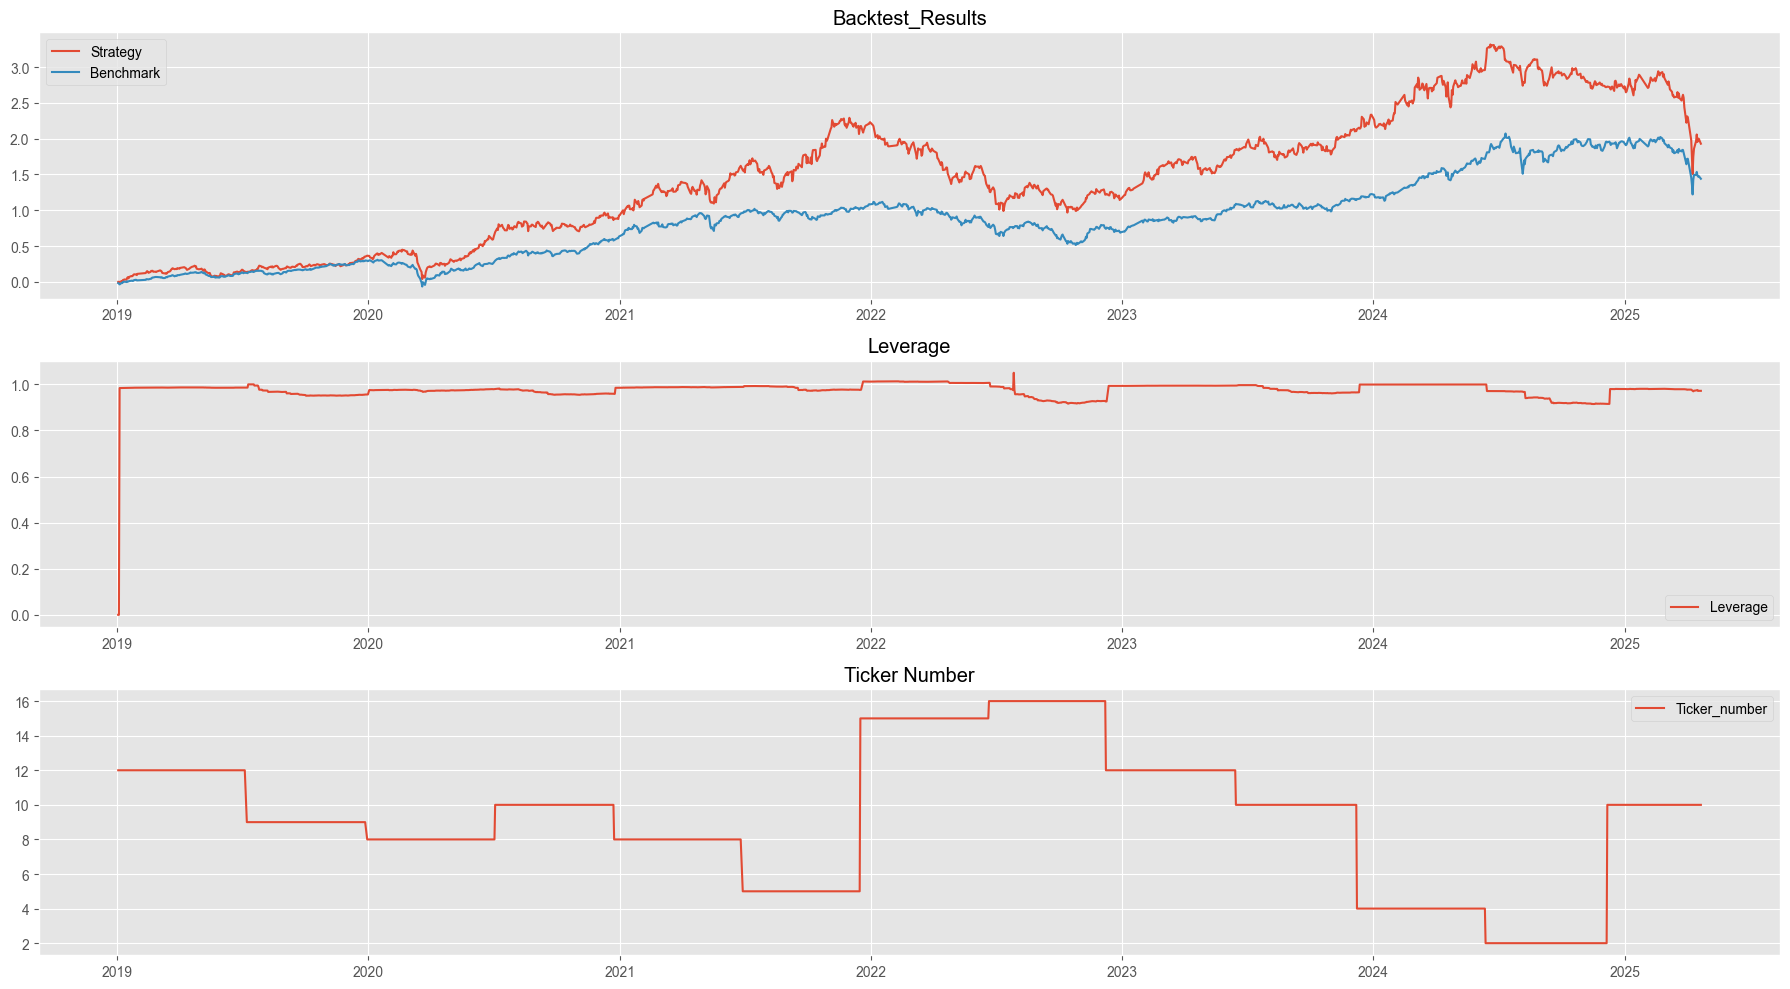

In [17]:
def analyze(context, perf):
  fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10), sharex=False)
  plt.style.use('ggplot')
  axes[0].plot(perf.index, perf['algorithm_period_return'], label = 'Strategy')
  axes[0].plot(perf.index, perf['benchmark_period_return'], label = 'Benchmark')
  axes[0].set_title(f"Backtest_Results")
  axes[0].legend()

  axes[1].plot(perf.index, perf['Leverage'], label = 'Leverage')
  axes[1].set_title(f"Leverage")
  axes[1].legend()

  axes[2].plot(perf.index, perf['ticker_num'], label = 'Ticker_number')
  axes[2].set_title(f'Ticker Number')
  axes[2].legend()
  plt.tight_layout()
  plt.show()

results = run_algorithm(
            start = pd.Timestamp('2019-01-01', tz = 'utc'),
            end = pd.Timestamp(end_date, tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_1,
            analyze = analyze,
            bundle = 'tquant',
            capital_base = 1e5)

Start date,2019-01-02
End date,2025-04-21
Total months,72
,Backtest
Annual return,19.426%
Cumulative returns,193.001%
Annual volatility,26.426%
Sharpe ratio,0.80
Calmar ratio,0.46
Stability,0.85
Max drawdown,-41.937%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.94,2024-06-19,2025-04-09,NaT,NaN
1,40.22,2021-11-30,2022-10-13,2023-12-15,498
2,28.31,2020-02-19,2020-03-19,2020-06-03,72
3,15.67,2021-07-12,2021-08-17,2021-09-23,52
4,13.43,2021-04-29,2021-05-17,2021-06-08,28


Top 10 long positions of all time,max
sid,
1722,52.31%
3034,49.40%
3533,33.69%
3653,31.94%
3529,31.82%
8046,25.10%
5269,24.62%
3293,21.10%
2059,21.03%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
1722,52.31%
3034,49.40%
3533,33.69%
3653,31.94%
3529,31.82%
8046,25.10%
5269,24.62%
3293,21.10%
2059,21.03%


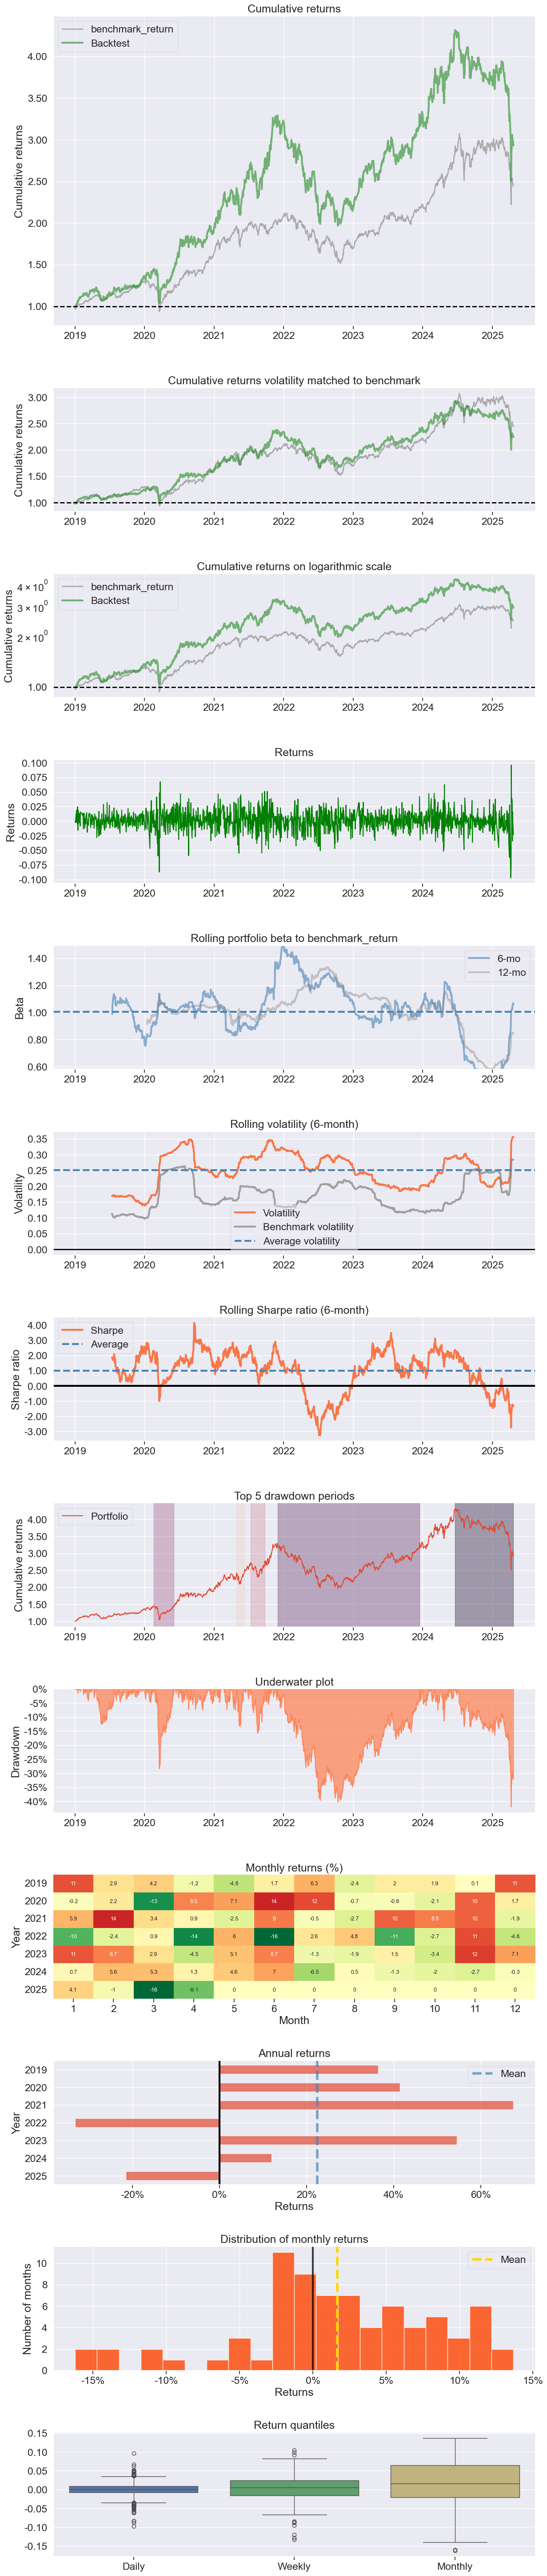

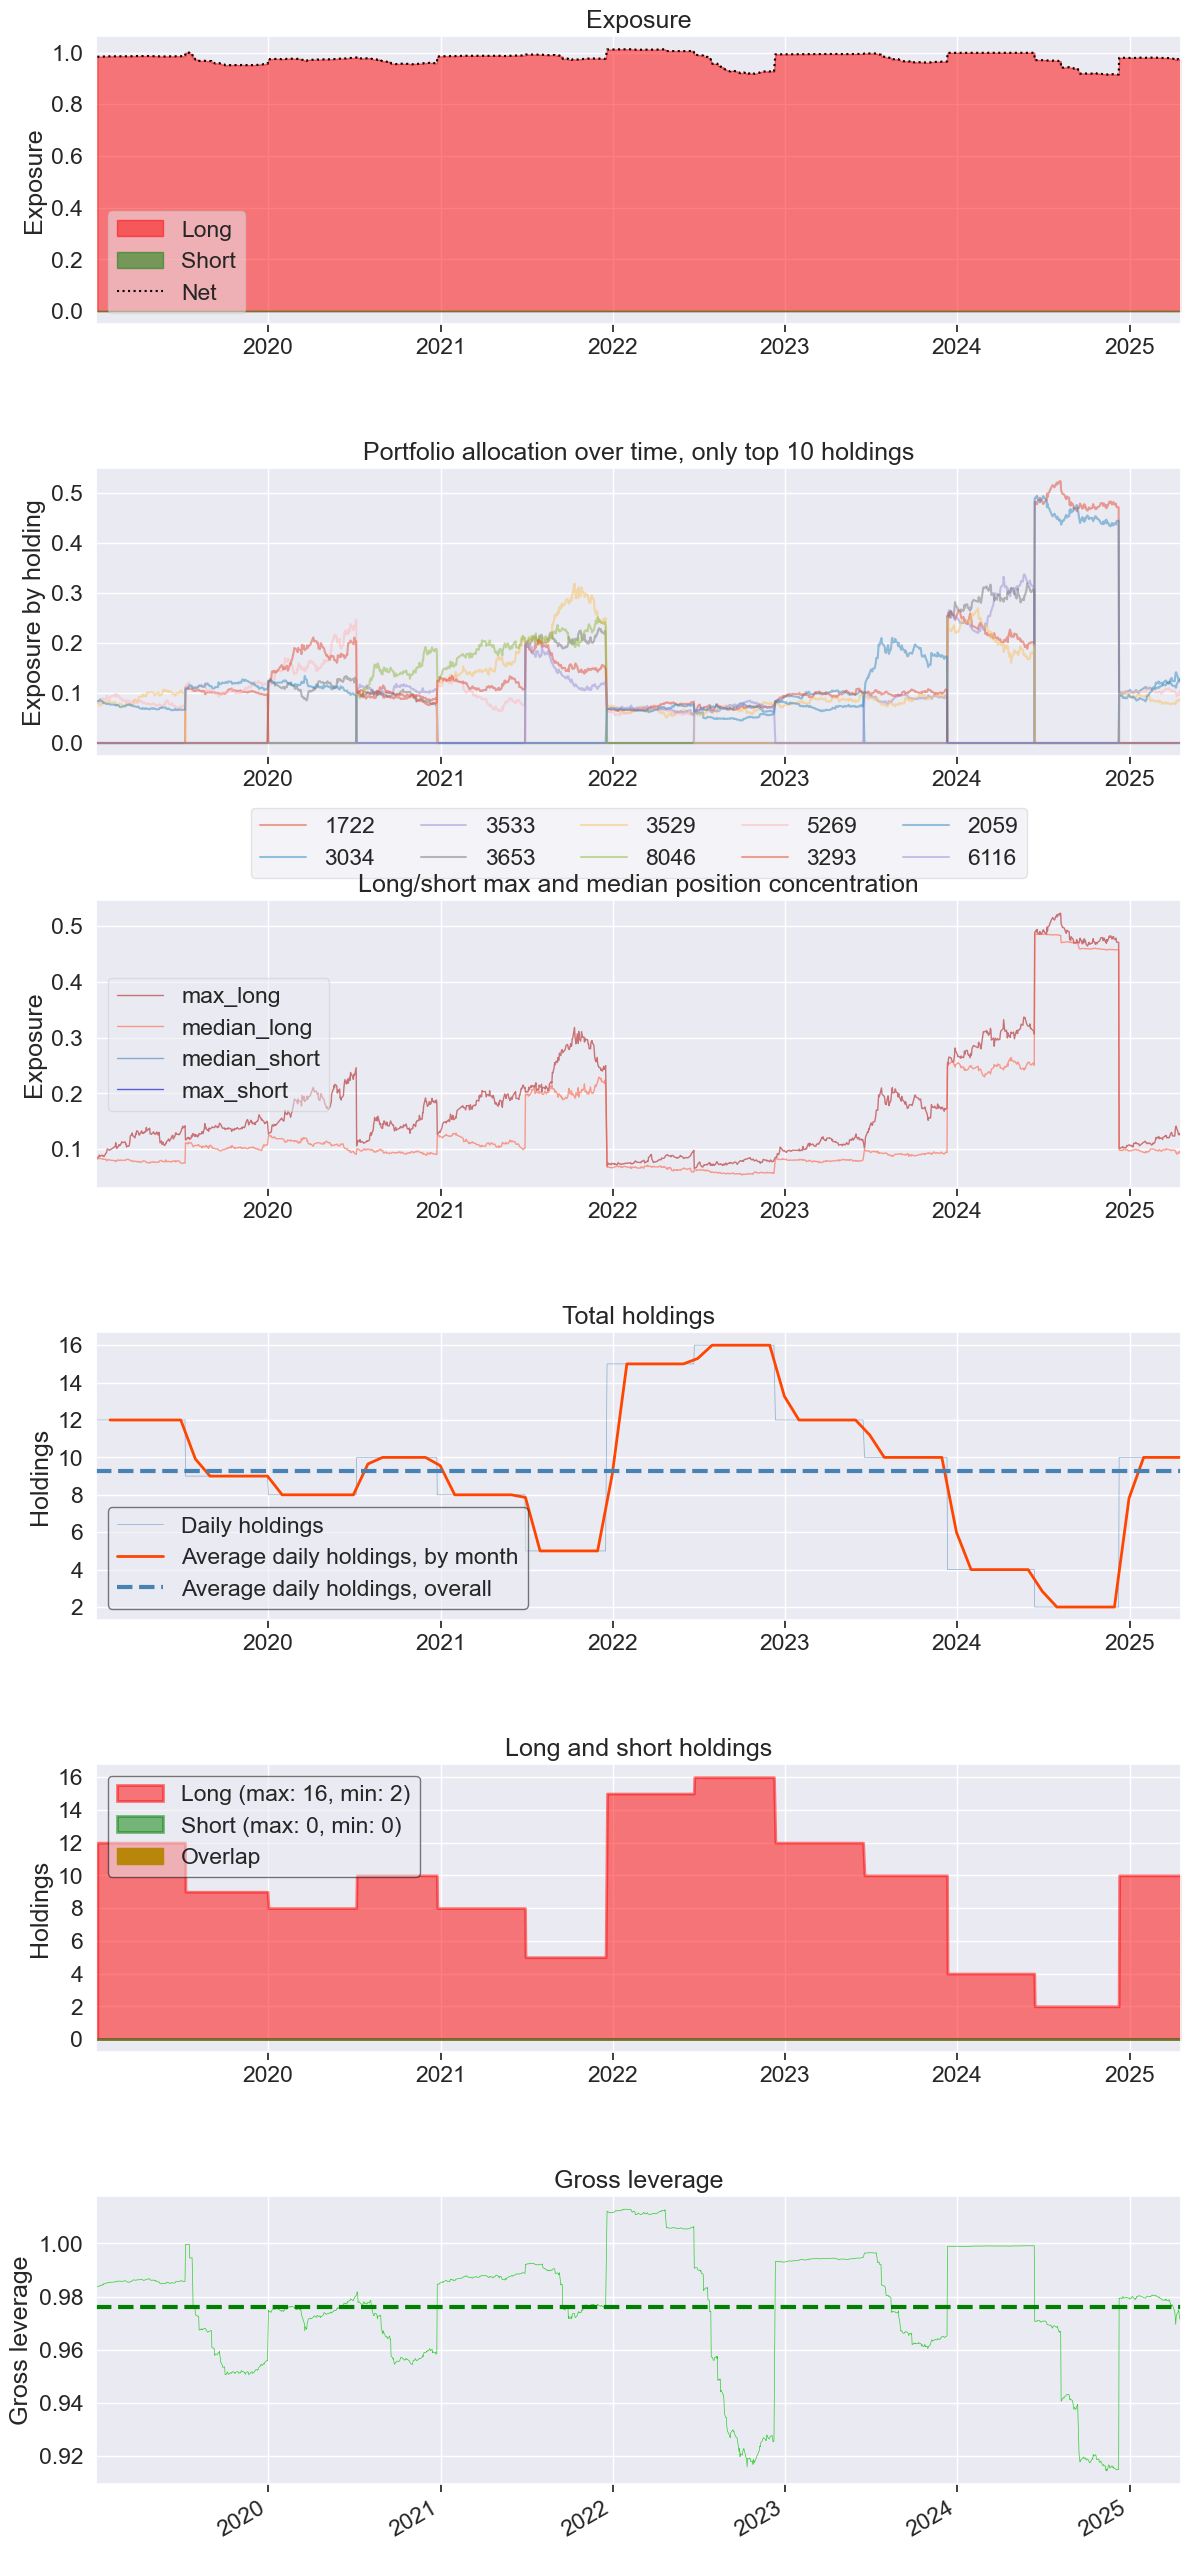

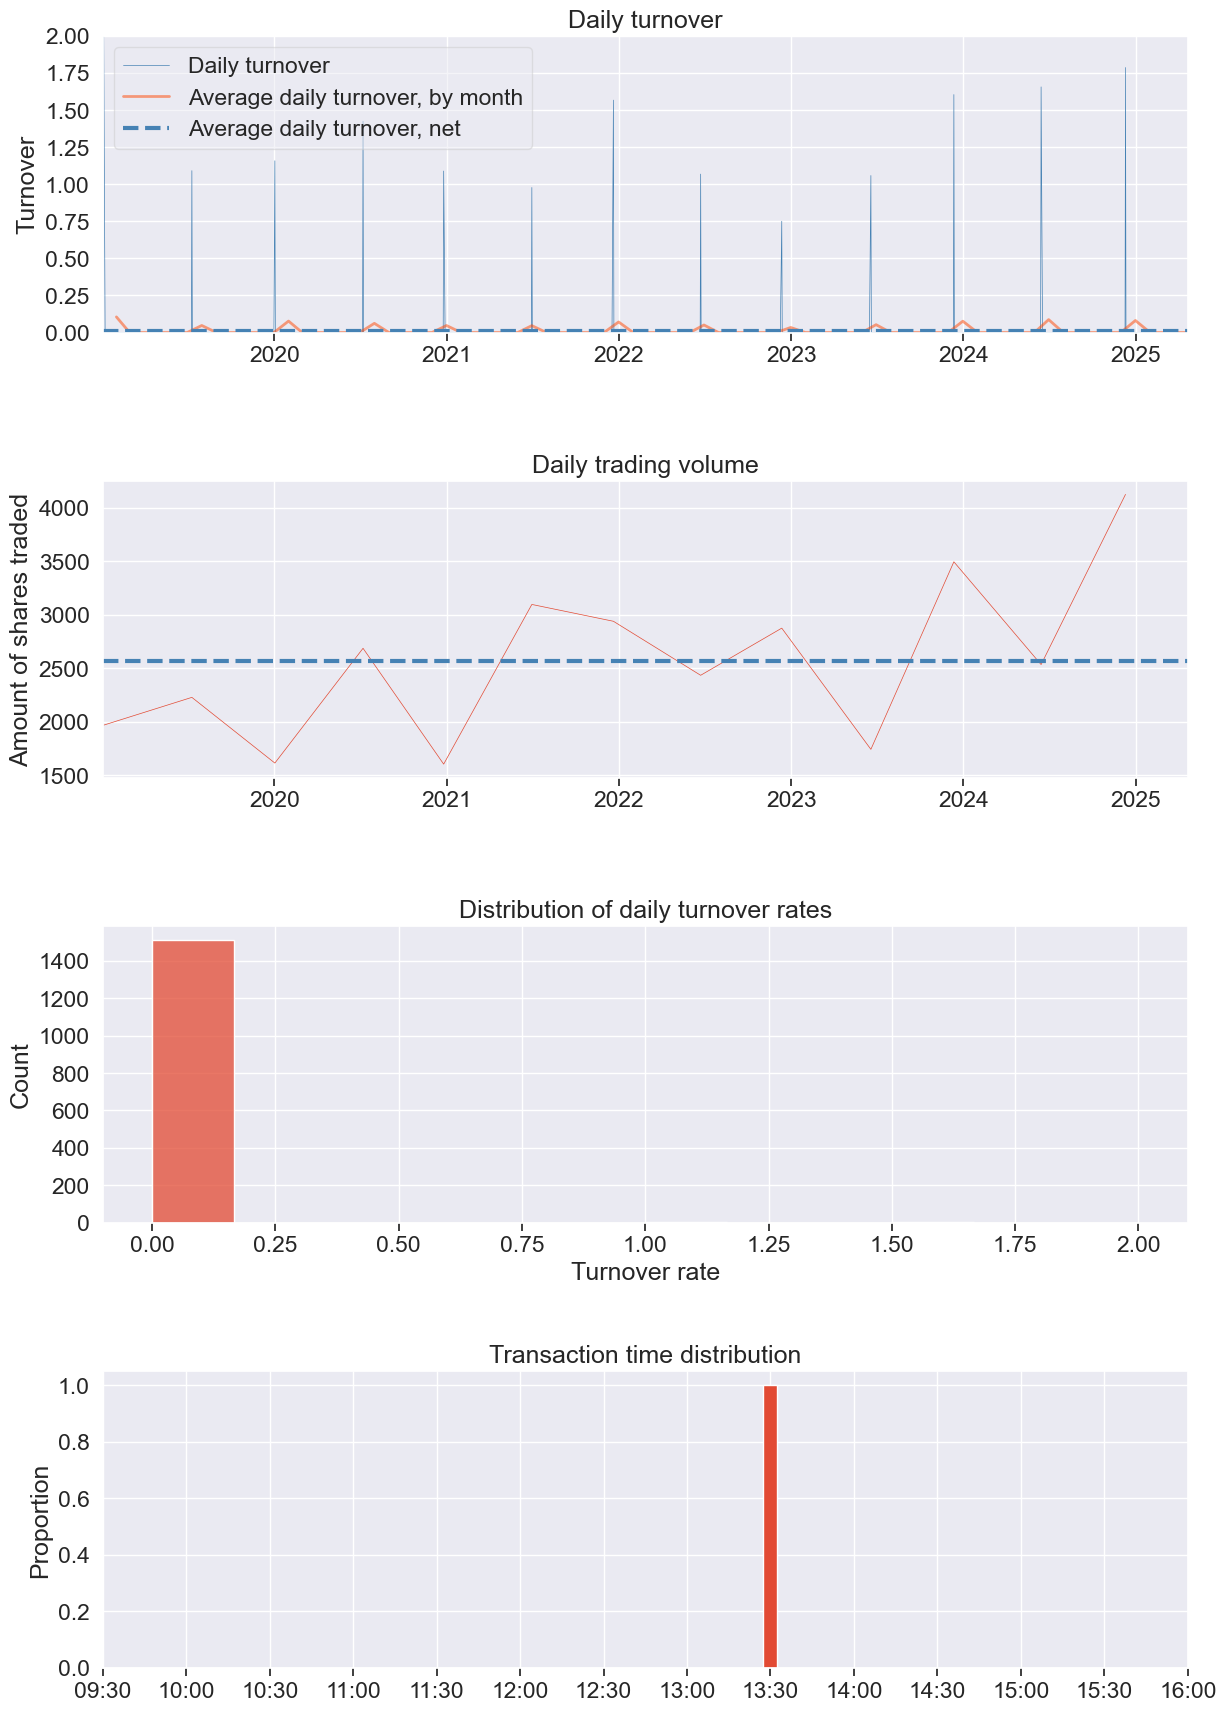

In [19]:
import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )